In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

########################################
# 1. 工具函数
########################################

def map_categories(df, col_name):
    """
    将 DataFrame 中 col_name 列的类别值映射为整数 ID。
    保留 0 作为“未知或填充”索引，以应对测试集可能出现的未见类别。
    返回：mapped_series, cat2id, 其中
      - mapped_series：将 df[col_name] 映射后的 pd.Series
      - cat2id：类别到索引的字典 {类别值: 整数ID}
    """
    unique_cats = df[col_name].unique().tolist()
    # 从 1 开始编号，0 留给未知
    cat2id = {}
    idx_start = 1
    for i, cat in enumerate(unique_cats):
        cat2id[cat] = i + idx_start

    # 将原列映射到 ID，未知值映射为 0
    mapped_series = df[col_name].map(lambda x: cat2id.get(x, 0))
    return mapped_series, cat2id


def create_sequences(data, seq_length, pred_length=10):
    """
    data: shape (N, n_features)
    这里只预测 MidpointPrice (假定它在 data 的特征索引 mid_price_idx = 6).
    根据自己的 numeric_cols 顺序来设定 mid_price_idx.
    返回:
      X: (num_samples, seq_length, n_features)
      Y: (num_samples, pred_length, 1)   只预测价格
    """
    X, Y = [], []
    n = len(data)

    # 假设 numeric_cols = [
    #   "bidVolume", "bidPrice", "askVolume", "askPrice",
    #   "OrderFlowImbalance", "WeightedSpread", "MidpointPrice"
    # ]
    # 所以 MidpointPrice 在 numeric_cols 中的索引是6 => 在组合数据中的位置是6
    # (后面还拼了 stock_id, period_id => 它们索引依次为 7,8, 但这里只预测第6列)
    mid_price_idx = 6

    for i in range(n - seq_length - pred_length + 1):
        seq_x = data[i : i + seq_length]  # shape (seq_length, n_features)
        seq_y = data[i + seq_length : i + seq_length + pred_length, mid_price_idx]
        # seq_y shape: (pred_length,)

        X.append(seq_x)
        # 让 Y 最终变成 (pred_length, 1)
        Y.append(seq_y.reshape(-1, 1))

    return np.array(X), np.array(Y)


def load_data(train_path, test_path, seq_length=60, pred_length=10, batch_size=32):
    # 1. 读取数据
    train_df = pd.read_csv(train_path)
    test_df  = pd.read_csv(test_path)

    # 2. 先补充或计算 MidpointPrice (如原数据未提供，可自行计算)
    #   如果你的数据已经有 MidpointPrice，就不需要这步
    if "MidpointPrice" not in train_df.columns:
        train_df["MidpointPrice"] = (train_df["bidPrice"] + train_df["askPrice"]) / 2
    if "MidpointPrice" not in test_df.columns:
        test_df["MidpointPrice"] = (test_df["bidPrice"] + test_df["askPrice"]) / 2

    # 3. 定义数值特征列 (只举例)
    numeric_cols = [
        "bidVolume", "bidPrice",
        "askVolume", "askPrice",
        "OrderFlowImbalance",
        "WeightedSpread",
        "MidpointPrice"  # 只预测这个，但一起作为输入
    ]

    # 4. 将 stock、period 转为 ID
    train_df["stock_id"], stock2id = map_categories(train_df, "stock")
    test_df["stock_id"] = test_df["stock"].map(lambda x: stock2id.get(x, 0))  # 未见类别 => 0

    train_df["period_id"], period2id = map_categories(train_df, "period")
    test_df["period_id"] = test_df["period"].map(lambda x: period2id.get(x, 0))

    # 统计类别总数, 用于 embedding 的 vocab_size
    stock_vocab_size = len(stock2id) + 1  # +1 预留 index=0
    period_vocab_size = len(period2id) + 1

    # 5. 分离数值列，用 MinMaxScaler 做归一化
    train_numeric = train_df[numeric_cols].values  # shape: (N_train, len(numeric_cols))
    test_numeric  = test_df[numeric_cols].values   # shape: (N_test,  len(numeric_cols))

    scaler = MinMaxScaler(feature_range=(0, 1))
    train_numeric_scaled = scaler.fit_transform(train_numeric)
    test_numeric_scaled  = scaler.transform(test_numeric)

    # 6. 拼接数值特征与 (stock_id, period_id)，得到最终输入
    #    numeric_size = len(numeric_cols)，stock_id, period_id 各1列
    #    => 最终 shape: (N, numeric_size + 2)
    train_combined = np.hstack([
        train_numeric_scaled,
        train_df["stock_id"].values.reshape(-1, 1),
        train_df["period_id"].values.reshape(-1, 1)
    ])
    test_combined = np.hstack([
        test_numeric_scaled,
        test_df["stock_id"].values.reshape(-1, 1),
        test_df["period_id"].values.reshape(-1, 1)
    ])

    # 7. 生成序列数据
    X_train, Y_train = create_sequences(train_combined, seq_length, pred_length)
    X_test,  Y_test  = create_sequences(test_combined,  seq_length, pred_length)

    print("[DEBUG] X_train.shape =", X_train.shape, " Y_train.shape =", Y_train.shape)
    print("[DEBUG] X_test.shape  =", X_test.shape,  "  Y_test.shape =", Y_test.shape)

    # 8. 转为 tensor
    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    Y_train_t = torch.tensor(Y_train, dtype=torch.float32)  # (batch, pred_len, 1)
    X_test_t  = torch.tensor(X_test,  dtype=torch.float32)
    Y_test_t  = torch.tensor(Y_test,  dtype=torch.float32)

    train_dataset = TensorDataset(X_train_t, Y_train_t)
    test_dataset  = TensorDataset(X_test_t,  Y_test_t)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

    # 返回需要的对象
    numeric_size = len(numeric_cols)
    return (train_loader, test_loader,
            scaler,
            X_test_t, Y_test_t,
            numeric_size,
            stock_vocab_size,
            period_vocab_size
           )




In [ ]:

########################################
# 2. 定义带有 Embedding 的 LSTM 模型
########################################

class StockLSTM(nn.Module):
    def __init__(self,
                 numeric_size,         # 数值特征维度
                 stock_vocab_size,     # stock embedding 的词典大小
                 period_vocab_size,    # period embedding 的词典大小
                 stock_emb_dim=4,
                 period_emb_dim=4,
                 hidden_size=128,
                 num_layers=2,
                 output_size=10):
        """
        说明：
          - numeric_size: 数值特征的维度 (比如7个数值特征)
          - stock_vocab_size: stock_id 的取值总数(含0)
          - period_vocab_size: period_id 的取值总数(含0)
          - stock_emb_dim, period_emb_dim: Embedding输出维度可自行调参
          - hidden_size, num_layers: LSTM 相关超参
          - output_size: 一次性要输出的 pred_length
        """
        super(StockLSTM, self).__init__()

        # Embedding层: padding_idx=0 用来处理“未见类别”
        self.stock_emb = nn.Embedding(num_embeddings=stock_vocab_size,
                                      embedding_dim=stock_emb_dim,
                                      padding_idx=0)
        self.period_emb = nn.Embedding(num_embeddings=period_vocab_size,
                                       embedding_dim=period_emb_dim,
                                       padding_idx=0)

        self.numeric_size = numeric_size
        self.stock_emb_dim = stock_emb_dim
        self.period_emb_dim = period_emb_dim

        # LSTM 输入维度 = 数值特征 + stock_emb_dim + period_emb_dim
        input_dim = numeric_size + stock_emb_dim + period_emb_dim

        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True)

        # 全连接层输出
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        x shape: (batch_size, seq_length, numeric_size + 2)
                 其中后2列是 stock_id, period_id
        """
        # 1) 拆分数值特征 + 分类ID
        #   numeric部分: x[..., :self.numeric_size]
        #   stock_id:    x[..., self.numeric_size]   (batch, seq_len)
        #   period_id:   x[..., self.numeric_size+1] (batch, seq_len)
        numeric_part = x[..., :self.numeric_size]               # float
        stock_id_part = x[..., self.numeric_size].long()        # long
        period_id_part = x[..., self.numeric_size+1].long()     # long

        # 2) Embedding
        stock_embedded = self.stock_emb(stock_id_part)   # (batch, seq_len, stock_emb_dim)
        period_embedded = self.period_emb(period_id_part)# (batch, seq_len, period_emb_dim)

        # 3) 拼接在特征维度
        combined = torch.cat([numeric_part, stock_embedded, period_embedded], dim=-1)
        # combined shape: (batch, seq_len, numeric_size + stock_emb_dim + period_emb_dim)

        # 4) 送入 LSTM
        #    LSTM 只要最终的 hidden state
        _, (hn, _) = self.lstm(combined)   # hn shape: (num_layers, batch_size, hidden_size)
        # 取最后一层的 hidden: hn[-1] => (batch_size, hidden_size)
        out = self.fc(hn[-1])  # => (batch_size, output_size)
        return out




In [ ]:
########################################
# 3. 训练 & 测试
########################################

if __name__ == "__main__":
    # 1) 参数设置
    TRAIN_CSV_PATH = "/content/drive/MyDrive/Colab_Notebooks/McHacks/featured_data/A_stock_train.csv"
    TEST_CSV_PATH  = "/content/drive/MyDrive/Colab_Notebooks/McHacks/featured_data/A_stock_test.csv"

    seq_len = 60
    pred_length = 1
    batch_size  = 32

    # 2) 读取 & 加载数据
    (train_loader, test_loader,
     scaler,
     X_test_t, Y_test_t,
     numeric_size,
     stock_vocab_size,
     period_vocab_size
    ) = load_data(
        TRAIN_CSV_PATH,
        TEST_CSV_PATH,
        seq_length=seq_len,
        pred_length=pred_length,
        batch_size=batch_size
    )

    # 3) 实例化模型
    stock_emb_dim = 4      # 可以自行调大
    period_emb_dim = 4     # 可以自行调大
    hidden_size = 128
    num_layers  = 2

    model = StockLSTM(
        numeric_size=numeric_size,
        stock_vocab_size=stock_vocab_size,
        period_vocab_size=period_vocab_size,
        stock_emb_dim=stock_emb_dim,
        period_emb_dim=period_emb_dim,
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=pred_length
    )

    # 4) 定义损失 & 优化器
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 5) 训练
    epochs = 5
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for X_batch, Y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            optimizer.zero_grad()
            y_pred = model(X_batch)  # shape: (batch_size, pred_length)
            y_true = Y_batch.squeeze(-1)  # => (batch_size, pred_length)
            loss = criterion(y_pred, y_true)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")




[DEBUG] X_train.shape = (46734, 60, 9)  Y_train.shape = (46734, 1, 1)
[DEBUG] X_test.shape  = (3540, 60, 9)   Y_test.shape = (3540, 1, 1)


Epoch 1/5: 100%|██████████| 1461/1461 [00:31<00:00, 45.81it/s]


Epoch 1/5, Loss: 0.0016


Epoch 2/5: 100%|██████████| 1461/1461 [00:31<00:00, 46.55it/s]


Epoch 2/5, Loss: 0.0001


Epoch 3/5: 100%|██████████| 1461/1461 [00:31<00:00, 45.72it/s]


Epoch 3/5, Loss: 0.0001


Epoch 4/5: 100%|██████████| 1461/1461 [00:31<00:00, 47.10it/s]


Epoch 4/5, Loss: 0.0000


Epoch 5/5: 100%|██████████| 1461/1461 [00:31<00:00, 46.39it/s]

Epoch 5/5, Loss: 0.0000


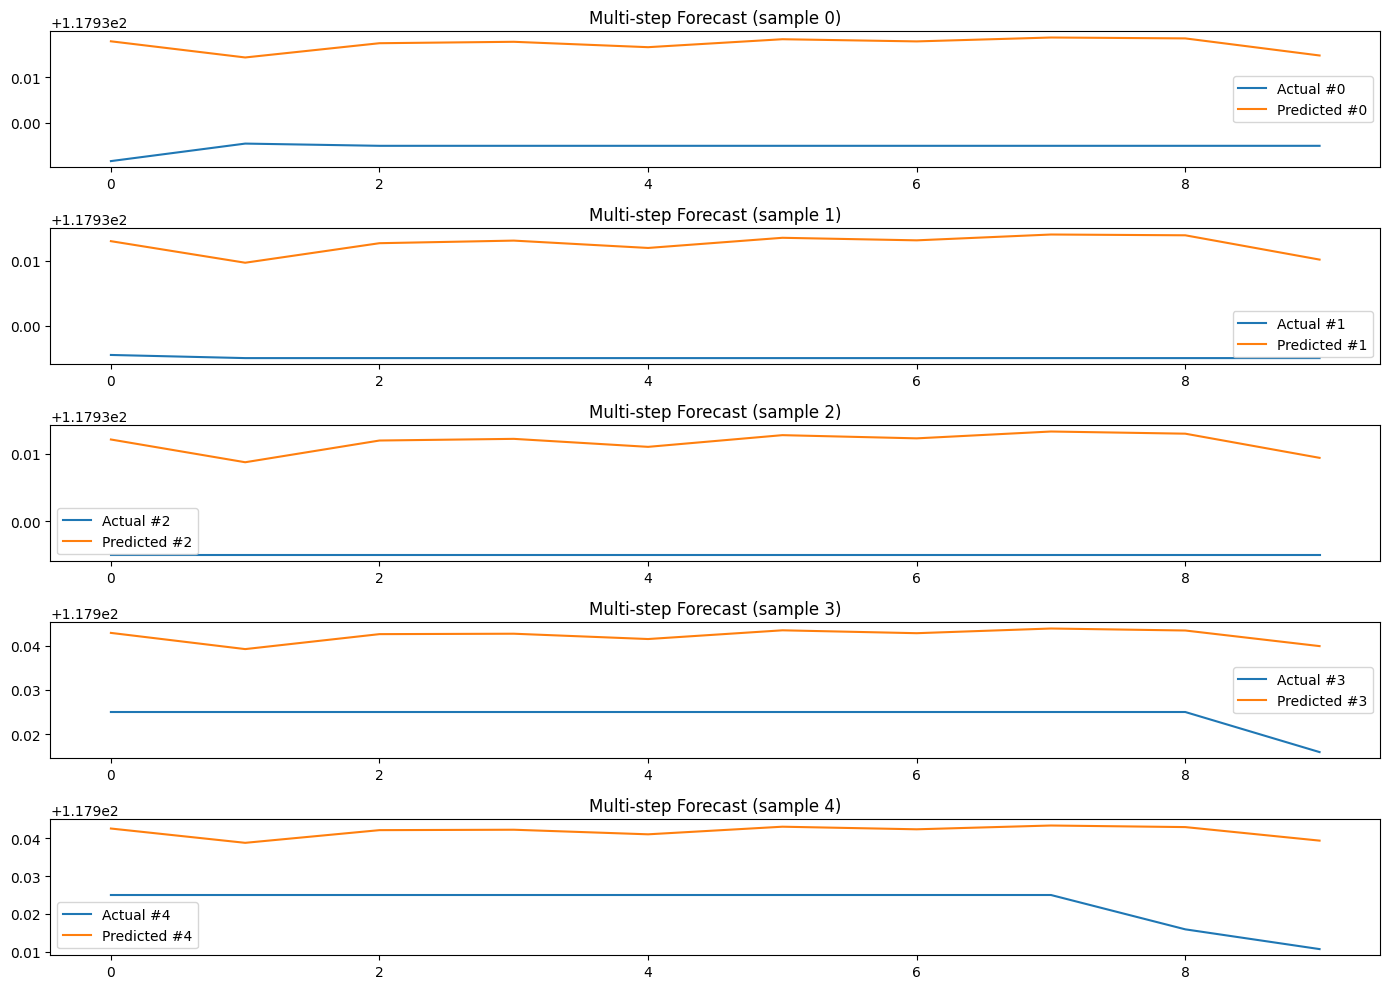

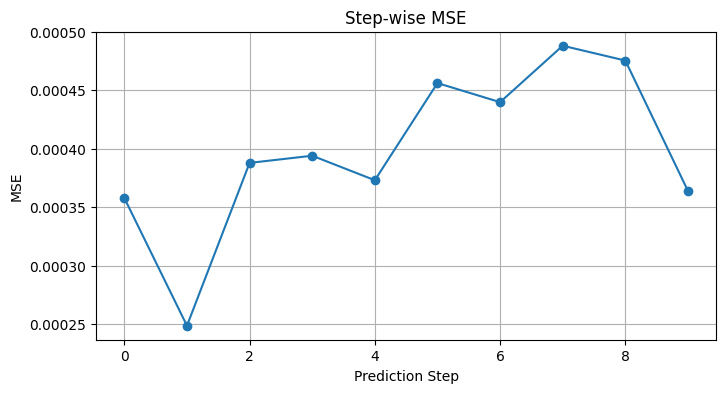

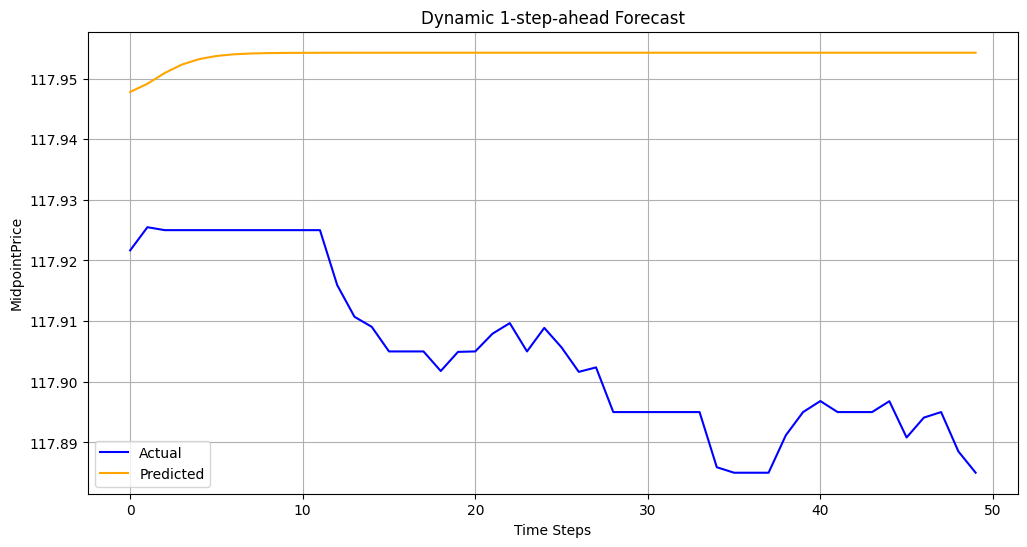

In [ ]:
    ########################################
    # 4. 测试阶段
    ########################################
    torch.save(model.state_dict(), "/content/drive/MyDrive/Colab_Notebooks/McHacks/saved_models/LSTM.pth")

    # (A) 整体预测
    model.eval()
    with torch.no_grad():
        y_pred_t = model(X_test_t)  # (N_test, pred_length)
        y_true_t = Y_test_t         # (N_test, pred_length, 1)

    # 转 numpy
    y_pred_np = y_pred_t.cpu().numpy()                 # (N_test, pred_length)
    y_true_np = y_true_t.squeeze(-1).cpu().numpy()     # (N_test, pred_length)

    # (B) 逆归一化
    # 由于我们只对数值特征做了统一归一化，且 MidpointPrice 在 numeric_cols 里。
    # 需要先“解开” y_pred_np 到原始价格尺度。
    # 方法：我们可以将 y_pred_np 并入到一个临时 array 在 mid_price_idx 位置，然后再 inverse_transform。
    mid_price_idx = 6  # numeric_cols 中 MidpointPrice 的索引
    def inverse_transform_prediction(pred_np):
        """
        pred_np shape: (N_test, pred_length)
        返回同形状的逆变换结果
        """
        # 构建 (N_test, len(numeric_cols)) 的空容器，把 MidpointPrice 位置放 pred，再 inverse_transform
        N = pred_np.shape[0]
        tmp = np.zeros((N, len(numeric_size)))  # 注意 numeric_size 是个 int，不是 list。这里写错了
        # 纠正： numeric_size = 7 (举例)。故 tmp = np.zeros((N, numeric_size))
        # 但 pred_length 不同 => 这里多步预测要逐步处理。
        # 常见做法：逐点 inverse_transform。但在多步预测时，每一步都是单独 inverse。
        # 简化处理：我们可以对 y_pred_np 的每个时间步都单独做一次 inverse_transform
        # 整体流程如下：

        raise NotImplementedError("多步预测的逆变换需要单步进行，下面我们演示简单做法。")

    # -- 更常见的处理：把 y_pred_np 和 y_true_np 展开到一维后 inverse_transform，再 reshape --
    y_pred_flat = y_pred_np.reshape(-1, 1)  # => (N_test * pred_length, 1)
    y_true_flat = y_true_np.reshape(-1, 1)

    # 拼一个容器用来放 numeric_features
    # 先随机拿一个已有数值特征行（比如 zeros），放在其他列，不影响结果；只对 price 列做替换
    # 这里用 0 填充其他列，然后 inverse_transform
    dummy_other_cols = np.zeros((len(y_pred_flat), numeric_size - 1))
    # 因为 numeric_size=7， 其中 1 个是 MidpointPrice，剩余6个是别的列

    # pred 的 shape => (N*pred_length, 1)
    # cat => shape (N*pred_length, numeric_size)
    cat_pred = np.hstack([dummy_other_cols[:, :mid_price_idx],    # 0~5列
                          y_pred_flat,                            # 第6列
                          dummy_other_cols[:, mid_price_idx:]     # 余下列(如果有)
                         ])
    cat_true = np.hstack([dummy_other_cols[:, :mid_price_idx],
                          y_true_flat,
                          dummy_other_cols[:, mid_price_idx:]
                         ])

    # 做逆归一化
    # 注意：scaler 是 fit 在 train_numeric 上的 (N_train, numeric_size)
    # shape 必须与当初 fit 的维度匹配
    pred_inv_all = scaler.inverse_transform(cat_pred)  # (N*pred_length, numeric_size)
    true_inv_all = scaler.inverse_transform(cat_true)

    # 只取第 mid_price_idx 列 => 即原始价格
    y_pred_inv_flat = pred_inv_all[:, mid_price_idx]
    y_true_inv_flat = true_inv_all[:, mid_price_idx]

    # reshape 回 (N_test, pred_length)
    y_pred_inv = y_pred_inv_flat.reshape(-1, pred_length)
    y_true_inv = y_true_inv_flat.reshape(-1, pred_length)

    # (C) 画图 - 多步预测对比
    num_samples_to_plot = 5
    sample_indices = range(num_samples_to_plot)

    plt.figure(figsize=(14, 10))
    for i, sample_idx in enumerate(sample_indices):
        plt.subplot(num_samples_to_plot, 1, i + 1)
        plt.plot(y_true_inv[sample_idx], label=f"Actual #{sample_idx}")
        plt.plot(y_pred_inv[sample_idx], label=f"Predicted #{sample_idx}")
        plt.title(f"Multi-step Forecast (sample {sample_idx})")
        plt.legend()
    plt.tight_layout()
    plt.show()

    # (D) 计算每个预测步的 MSE
    stepwise_mse = [
        mean_squared_error(y_true_inv[:, step], y_pred_inv[:, step])
        for step in range(pred_length)
    ]
    plt.figure(figsize=(8, 4))
    plt.plot(range(pred_length), stepwise_mse, marker='o')
    plt.title("Step-wise MSE")
    plt.xlabel("Prediction Step")
    plt.ylabel("MSE")
    plt.grid(True)
    plt.show()


    ########################################
    # 5. (可选) 动态多步预测示例
    ########################################
    # 这里演示用测试集的第一个样本作为初始history，滚动预测后一个时间步并不断更新。
    # 仅用于演示 embedding 拼接后的滑窗思路和逆变换处理。
    dynamic_pred_steps = 50  # 想要往后滚动多少步
    history = X_test_t[0].unsqueeze(0)  # shape: (1, seq_len, numeric_size+2)
    dynamic_predictions = []
    true_prices = []

    with torch.no_grad():
        for i in range(dynamic_pred_steps):
            # 1) 当前history 送进模型，一次性输出 pred_length 步
            pred = model(history)  # shape: (1, pred_length)

            # 2) 取第 1 步预测值（如果你想用多步也可以改逻辑）
            first_pred = pred[:, 0]  # shape: (1,)
            dynamic_predictions.append(first_pred.item())

            # 3) 同时取真实值 (对应 Y_test_t[i, 0, 0]) => 仅演示
            if i < len(Y_test_t):
                true_prices.append(Y_test_t[i, 0, 0].item())
            else:
                true_prices.append(np.nan)

            # 4) 滑动窗口: 把预测值当做下一时刻输入
            #    需要在 numeric_size+2 的正确位置写入
            #    其中 mid_price_idx=6 => numeric_part[6] 要用 new_pred
            #    同时 stock_id, period_id 该怎么处理视业务而定，下面仅演示
            #    如果 period, stock 都是一样，可以直接复制上一个时刻的ID
            new_input = history[:, -1, :].clone()  # (1, n_features)

            # 将 MidpointPrice 的位置替换为本次预测
            new_input[0, 6] = first_pred  # mid_price_idx=6

            # 拼回到 seq_len
            #    原 history shape: (1, seq_len, n_features)
            #    去掉第1个时刻，再在最后加上 new_input
            history = torch.cat([history[:, 1:, :], new_input.unsqueeze(1)], dim=1)

    # 逆归一化 dynamic_predictions
    # 同理：要构造 (N, numeric_size) 去 inverse_transform
    dynamic_pred_array = np.array(dynamic_predictions).reshape(-1,1)
    dummy_size = dynamic_pred_array.shape[0]

    dummy_other_cols = np.zeros((dummy_size, numeric_size - 1))
    cat_pred = np.hstack([
        dummy_other_cols[:, :6],  # 0~5
        dynamic_pred_array,
        dummy_other_cols[:, 6:]   # 如果 numeric_size>7，则这里再继续
    ])
    pred_inv_all = scaler.inverse_transform(cat_pred)
    dynamic_pred_inv = pred_inv_all[:, 6]  # mid_price_idx=6

    # 真实值 也做同样逆归一化
    true_prices_array = np.array(true_prices).reshape(-1,1)
    cat_true = np.hstack([
        dummy_other_cols[:, :6],
        true_prices_array,
        dummy_other_cols[:, 6:]
    ])
    true_inv_all = scaler.inverse_transform(cat_true)
    dynamic_true_inv = true_inv_all[:, 6]

    # 画图
    plt.figure(figsize=(12, 6))
    plt.plot(dynamic_true_inv, label="Actual", color="blue")
    plt.plot(dynamic_pred_inv, label="Predicted", color="orange")
    plt.title("Dynamic 1-step-ahead Forecast")
    plt.xlabel("Time Steps")
    plt.ylabel("MidpointPrice")
    plt.legend()
    plt.grid(True)
    plt.show()